<a href="https://colab.research.google.com/github/amir-asari/Qwen-VL-Basic/blob/main/QWen_VL_ZeroShotObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import re

#### --- 1. Environment Setup and Installation ---

In [1]:
# This block installs/upgrades libraries and forces a runtime restart.
print("Installing necessary packages...")


!pip install -q git+[https://github.com/huggingface/transformers.git](https://github.com/huggingface/transformers.git) accelerate
!pip install -q -U bitsandbytes
!pip install -q qwen-vl-utils pillow

Installing necessary packages...
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -q git+[https://github.com/huggingface/transformers.git](https://github.com/huggingface/transformers.git) accelerate'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 16.3 MB/s eta 0:00:00


#### --- 2. Imports and Model Loading (with 4-bit Quantization) ---

In [2]:
import torch
import warnings
import json
from PIL import Image
import requests
from io import BytesIO
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, BitsAndBytesConfig
from IPython.display import display

# --- NEW IMPORTS for Detection Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# ---------------------------------------------

# Suppress minor warnings for a clean output
warnings.filterwarnings('ignore')

# Switched to the smaller 3B model for compatibility and speed on T4 GPUs.
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"

# Check for GPU availability
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"--- Environment Setup ---")
print(f"Device: {device}")
print(f"Loading Model: {MODEL_ID} (with 4-bit Quantization)")
print("-" * 50)

model = None
try:
    # 1. Define 4-bit quantization configuration
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )

    # 2. Load the Model and Processor
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    processor = AutoProcessor.from_pretrained(MODEL_ID)

    # Load model using the 4-bit configuration
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        torch_dtype=dtype,
        device_map="auto",
    ).eval()
    print("Model loaded successfully in 4-bit precision.")

except Exception as e:
    print(f"Error loading model or libraries: {e}")
    print("Please ensure you have a T4 GPU enabled and the runtime has been restarted after installation.")
    model = None


--- Environment Setup ---
Device: cuda
Loading Model: Qwen/Qwen2.5-VL-3B-Instruct (with 4-bit Quantization)
--------------------------------------------------


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Model loaded successfully in 4-bit precision.


#### --- 3. Zero-Shot Detection Function ---

In [14]:
def zero_shot_detect(image_url: str, query_object: str):
    """
    Performs zero-shot object detection by instructing the Qwen model to output
    a JSON structure containing bounding box coordinates for a specific object.

    Returns: A dictionary containing the PIL Image and a list of detected objects.
    """
    if model is None:
        return {"error": "Model failed to load."}

    # 1. Download and load the image
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(image_url, stream=True, headers=headers)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        return {"error": f"Error loading image from URL: {e}"}

    # The prompt explicitly asks for JSON output with normalized bounding boxes (0-1000).
    # Qwen-VL is trained to understand grounding requests in this format.
    prompt_instruction = (
        f"Detect all instances of '{query_object}' in the image. "
        f"Output the results as a single JSON array of objects. "
        f"Each object must have two keys: 'box' (a list of 4 normalized integers: [x_min, y_min, x_max, y_max] where the maximum value is 1000) and 'label' (string). "
        f"DO NOT include any conversational text or explanation, ONLY output the JSON array."
    )

    # 2. Define the conversation
    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a professional object detection model. Your output must ONLY be a JSON array."}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt_instruction}
            ],
        }
    ]

    # 3. Process input and generate JSON text
    try:
        inputs = processor.apply_chat_template(
            conversation,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt"
        ).to(device)

        output_ids = model.generate(
            **inputs,
            do_sample=False,
            max_new_tokens=256, # Increased token limit to allow for complex JSON output
        )

        response_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Robustly clean the output to isolate the JSON block
        assistant_marker = "\nassistant\n"
        if assistant_marker in response_text:
            json_text = response_text.split(assistant_marker)[-1].strip()
        else:
            json_text = response_text.strip()

        # Regex to find the JSON array structure [ ... ]
        match = re.search(r'\[.*\]', json_text, re.DOTALL)

        if not match:
            return {"image": image, "detections": [], "error": f"JSON array not found in output: {json_text[:100]}..."}

        # 4. Parse the JSON output
        try:
            detections = json.loads(match.group(0))
            return {"image": image, "detections": detections, "error": None}
        except json.JSONDecodeError:
            return {"image": image, "detections": [], "error": f"Failed to parse valid JSON: {match.group(0)[:100]}..."}

    except Exception as e:
        return {"image": image, "detections": [], "error": f"Inference exception: {e}"}


def draw_detections(image: Image.Image, detections: list, title: str):
    """Draws bounding boxes and labels on the image and displays it."""

    if not detections:
        print(f"No detections found for: {title}")
        display(image)
        return

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    ax.set_title(title)

    img_width, img_height = image.size

    # Iterate through each detected object
    for det in detections:
        try:
            label = det.get('label', 'Unknown')
            # Normalized coordinates (0-1000) from Qwen
            x_min_norm, y_min_norm, x_max_norm, y_max_norm = det['box']

            # Convert normalized coordinates (0-1000) back to pixel values
            x_min = x_min_norm * img_width / 1000
            y_min = y_min_norm * img_height / 1000
            width = (x_max_norm - x_min_norm) * img_width / 1000
            height = (y_max_norm - y_min_norm) * img_height / 1000

            # Create a Rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add label text
            plt.text(
                x_min,
                y_min - 5,
                label,
                color='white',
                fontsize=12,
                bbox=dict(facecolor='r', alpha=0.7, edgecolor='none')
            )
        except Exception as e:
            print(f"Skipping malformed detection: {det}. Error: {e}")
            continue

    ax.axis('off') # Hide axes
    plt.show()

#### --- 4. Zero-Shot Detection Dataset and Execution ---


--- Starting Zero-Shot Object Detection ---

Detecting objects in: Street Scene: Cars and Lights | Query: 'car'
STATUS: Failed. Inference exception: CUDA out of memory. Tried to allocate 149.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.62 GiB is free. Process 8855 has 13.12 GiB memory in use. Of the allocated memory 11.88 GiB is allocated by PyTorch, and 1.11 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Detecting objects in: Birds on a Wire | Query: 'all birds'
STATUS: Success. Found 1 objects.


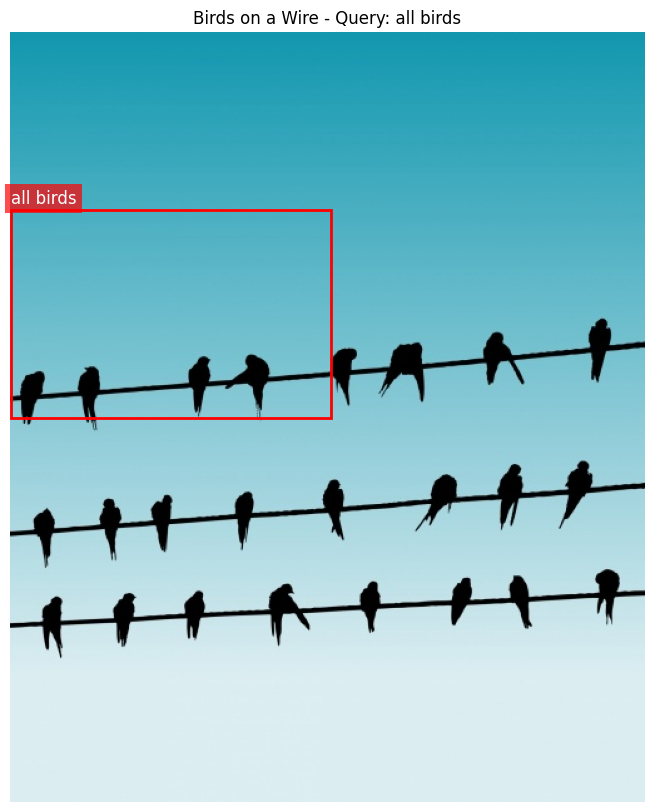


Detecting objects in: Dog in Snow | Query: 'circle'
STATUS: Success. Found 1 objects.


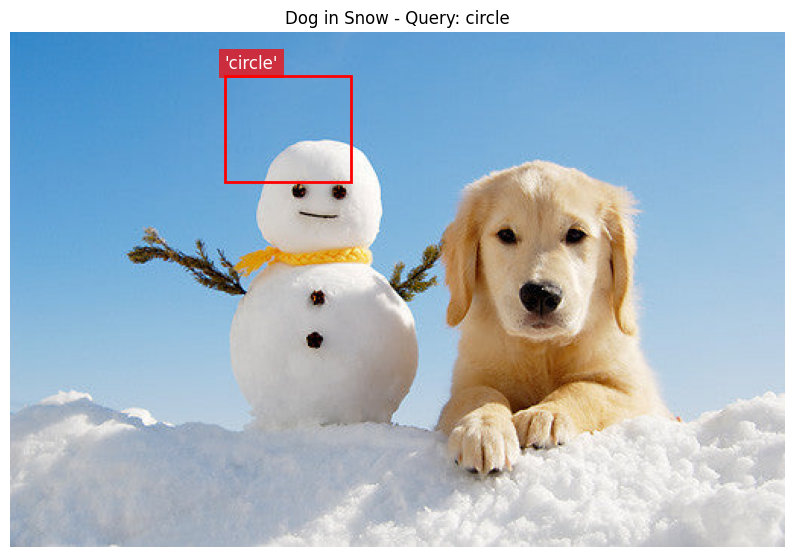

In [19]:
print("\n--- Starting Zero-Shot Object Detection ---")

# Define a simple dataset for detection testing
detection_dataset = [
    {
        "url": "https://images.pexels.com/photos/9767198/pexels-photo-9767198.jpeg",
        "query": "car",
        "title": "Street Scene: Cars and Lights"
    },
    {
        "url": "https://www.publicdomainpictures.net/pictures/350000/nahled/birds-on-a-wire-1592283974PGn.jpg",
        "query": "all birds",
        "title": "Birds on a Wire"
    },
    {
        "url": "https://whiskerbones.com/cdn/shop/articles/17.jpg?v=1483120953",
        "query": "circle",
        "title": "Dog in Snow"
    }
]

# Track metrics
total_runs = 0
successful_parses = 0

for item in detection_dataset:
    total_runs += 1

    print(f"\nDetecting objects in: {item['title']} | Query: '{item['query']}'")

    # Perform detection
    result = zero_shot_detect(item["url"], item["query"])

    if result.get('error'):
        print(f"STATUS: Failed. {result['error']}")
    else:
        successful_parses += 1
        print(f"STATUS: Success. Found {len(result['detections'])} objects.")
        draw_detections(result['image'], result['detections'], f"{item['title']} - Query: {item['query']}")




#### --- 5. Performance Summary ---

In [ ]:

print("\n\n" + "="*50)
print("--- 5. Object Detection Performance Summary ---")
print("="*50)

if total_runs > 0:
    parse_success_rate = (successful_parses / total_runs) * 100
    print(f"Total Test Runs: {total_runs}")
    print(f"Successful JSON Parses: {successful_parses}")
    print(f"JSON Parsing Success Rate: {parse_success_rate:.2f}%")
    print("\nNote: True detection accuracy (IoU) is not calculated here, as it requires ground-truth bounding box data.")
else:
    print("No test runs were executed.")